#Tourism hierarachy
https://github.com/erykml/medium_articles/blob/master/data/tourism.csv



The data set contains the quarterly number of trips to Australia between 1998 and 2016

**url** 
**date_of_publish** Mar 14 2021


**python package_name** orbit-ml

**github_page** https://github.com/uber/orbit

In [5]:
!pip install orbit-ml


     |████████████████████████████████| 112kB 8.4MB/s 
     |████████████████████████████████| 9.5MB 13.7MB/s 
     |████████████████████████████████| 11.6MB 265kB/s 
     |████████████████████████████████| 686kB 47.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)



In [2]:
!ls -al
!rm 'tourism.csv'

total 1620
drwxr-xr-x 1 root root    4096 Jul  7 17:57 .
drwxr-xr-x 1 root root    4096 Jul  7 17:52 ..
drwxr-xr-x 4 root root    4096 Jul  1 13:41 .config
drwxr-xr-x 1 root root    4096 Jul  1 13:42 sample_data
-rw-r--r-- 1 root root 1639195 Jul  7 17:57 tourism.csv


In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
from google.colab import files
uploaded = files.upload()  

Saving tourism.csv to tourism.csv


In [5]:
import io
# load the data 
df = pd.read_csv(io.BytesIO(uploaded['tourism.csv'])) \
       .drop(columns=["Unnamed: 0"])
# df = pd.read_csv('tourism.csv') \
#        .drop(columns=["Unnamed: 0"])

In [6]:
# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

df.head()

,quarter,region,state,trips,state_region
0,1998-01-01,Adelaide,SA,658.553895,SA_Adelaide
1,1998-01-01,Adelaide_Hills,SA,9.798630,SA_Adelaide_Hills
2,1998-01-01,Alice_Springs,NT,20.207638,NT_Alice_Springs
3,1998-01-01,Australias_Coral_Coast,WA,132.516409,WA_Australias_Coral_Coast
4,1998-01-01,Australias_Golden_Outback,WA,161.726948,WA_Australias_Golden_Outback


In [7]:
df.groupby("state")["region"].apply(set).to_frame()

,region
state,
ACT,{Canberra}
NSW,"{Central_Coast, North_Coast_NSW, New_England_N..."
NT,"{Hobart_and_the_South, Alice_Springs, Wilderne..."
QLD,"{Central_Queensland, Fraser_Coast, Sunshine_Co..."
SA,"{Adelaide, Kangaroo_Island, Clare_Valley, Fleu..."
VIC,"{Spa_Country, Bendigo_Loddon, Gippsland, Melbo..."
WA,"{Experience_Perth, Australias_South_West, Aust..."


In [8]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")


print(hierarchy_df.dtypes)
hierarchy_df.head()

Number of time series at the bottom level: 77
Number of time series at the middle level: 7
ACT_Canberra           float64
NSW_Blue_Mountains     float64
NSW_Capital_Country    float64
NSW_Central_Coast      float64
NSW_Central_NSW        float64
                        ...   
QLD                    float64
SA                     float64
VIC                    float64
WA                     float64
total                  float64
Length: 85, dtype: object


,ACT_Canberra,NSW_Blue_Mountains,NSW_Capital_Country,NSW_Central_Coast,NSW_Central_NSW,NSW_Hunter,NSW_New_England_North_West,NSW_North_Coast_NSW,NSW_Outback_NSW,NSW_Riverina,NSW_Snowy_Mountains,NSW_South_Coast,NSW_Sydney,NSW_The_Murray,NT_Alice_Springs,NT_Barkly,NT_Darwin,NT_East_Coast,NT_Hobart_and_the_South,NT_Kakadu_Arnhem,NT_Katherine_Daly,NT_Lasseter,"NT_Launceston,_Tamar_and_the_North",NT_MacDonnell,NT_North_West,NT_Tasmania,NT_Wilderness_West,QLD_Brisbane,QLD_Bundaberg,QLD_Central_Queensland,QLD_Darling_Downs,QLD_Fraser_Coast,QLD_Gold_Coast,QLD_Mackay,QLD_Northern,QLD_Outback,QLD_Sunshine_Coast,QLD_Tropical_North_Queensland,QLD_Whitsundays,SA_Adelaide,...,SA_Flinders_Ranges_and_Outback,SA_Kangaroo_Island,SA_Limestone_Coast,SA_Murraylands,SA_Riverland,SA_Yorke_Peninsula,VIC_Ballarat,VIC_Bendigo_Loddon,VIC_Central_Highlands,VIC_Central_Murray,VIC_Geelong,VIC_Gippsland,VIC_Goulburn,VIC_High_Country,VIC_Lakes,VIC_Macedon,VIC_Mallee,VIC_Melbourne,VIC_Melbourne_East,VIC_Murray_East,VIC_Peninsula,VIC_Phillip_Island,VIC_Spa_Country,VIC_Upper_Yarra,VIC_Western,VIC_Western_Grampians,VIC_Wimmera,WA_Australias_Coral_Coast,WA_Australias_Golden_Outback,WA_Australias_North_West,WA_Australias_South_West,WA_Experience_Perth,ACT,NSW,NT,QLD,SA,VIC,WA,total
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01,551.001921,195.543180,261.808142,455.166849,424.395446,674.978457,329.838506,1342.301230,96.602651,215.268912,140.989157,1257.446550,2288.955629,356.500087,20.207638,18.465206,87.607295,148.855652,380.602050,18.359518,16.771762,10.086239,247.595226,9.951165,141.241141,751.631888,63.335097,1052.194495,122.914282,191.589276,259.086028,173.961068,827.045761,128.935651,226.112807,37.196194,742.602300,220.915346,60.226649,658.553895,...,112.097738,34.678300,212.982623,68.004076,89.511377,160.681637,182.239342,231.685977,88.907326,196.298722,255.444832,382.608956,153.398516,320.504579,211.835892,24.790891,182.084599,1578.548409,86.852958,22.317190,694.723679,364.043288,86.196006,102.791022,739.350975,86.996591,18.804743,132.516409,161.726948,120.775450,474.858729,751.211958,551.001921,8039.794795,1914.709878,4042.779858,1732.743704,6010.424491,1641.089495,23932.544141
1998-04-01,416.025623,200.408671,238.600029,343.476758,557.011570,791.887234,328.366005,1161.108602,120.648446,336.094921,166.586342,795.074559,1814.459479,312.291189,56.356223,7.510969,116.864811,106.221127,226.909579,52.845863,40.806116,34.845044,172.854001,4.707126,144.696445,534.181412,42.607076,950.414816,110.058311,288.445257,439.035287,129.738887,680.774502,131.950023,159.481069,107.999764,609.883333,253.097616,106.190848,449.853934,...,122.200254,9.057817,154.772875,36.783256,98.747855,104.324252,136.663870,221.580799,105.157731,198.161741,190.532461,267.978316,177.725751,355.467743,245.945174,54.571687,186.326419,1506.071351,58.932986,30.996086,246.630629,166.243645,74.356890,74.855136,359.626051,84.939977,52.482311,172.615379,164.973780,158.404387,411.622281,668.710707,416.025623,7166.013805,1541.405790,3967.069713,1394.638319,4795.246755,1576.326534,20856.726540
1998-07-01,436.029011,253.359689,184.423751,303.670875,555.527970,566.040599,324.859168,839.368066,110.073779,228.065371,372.815339,643.280546,1989.731939,376.718698,110.918441,43.565625,179.903793,40.462620,176.902440,49.458990,81.973366,42.975636,90.604553,19.641008,75.054449,391.507192,18.851214,1002.765191,129.551542,288.227317,417.396506,182.498711,839.015762,154.908638,228.857258,234.743482,615.306331,423.506735,81.771005,592.904597,...,103.429609,10.464381,97.735163,43.497197,64.026915,68.996468,117.642761,128.054955,98.756975,112.972132,217.110171,257.236810,157.503674,356.656700,197.998048,21.606748,187.347077,1522.214955,66.816989,30.265351,183.430857,83.032823,60.778546,59.465405,342.321758,79.974884,35.657551,173.904335,206.879934,184.619035,360.039657,662.850731,436.029011,6747.935790,1321.819326,4598.548477,1213.330723,4316.845170,1588.293692,20222

In [9]:
states = df["state"].unique()
regions = df["state_region"].unique()

total = {'total': list(states)}
state = {k: [v for v in regions if v.startswith(k)] for k in states}
hierarchy = {**total, **state}

#hierarchy

#Visualizing the data

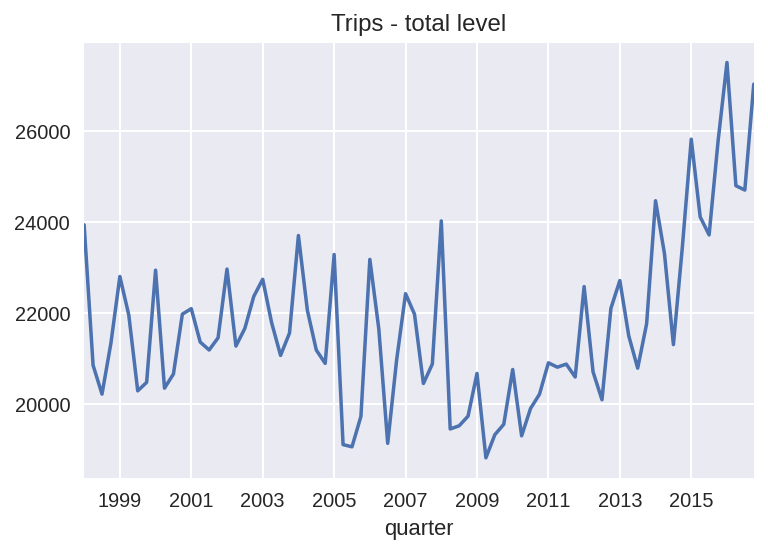

In [10]:
hierarchy_df["total"].plot(title="Trips - total level");

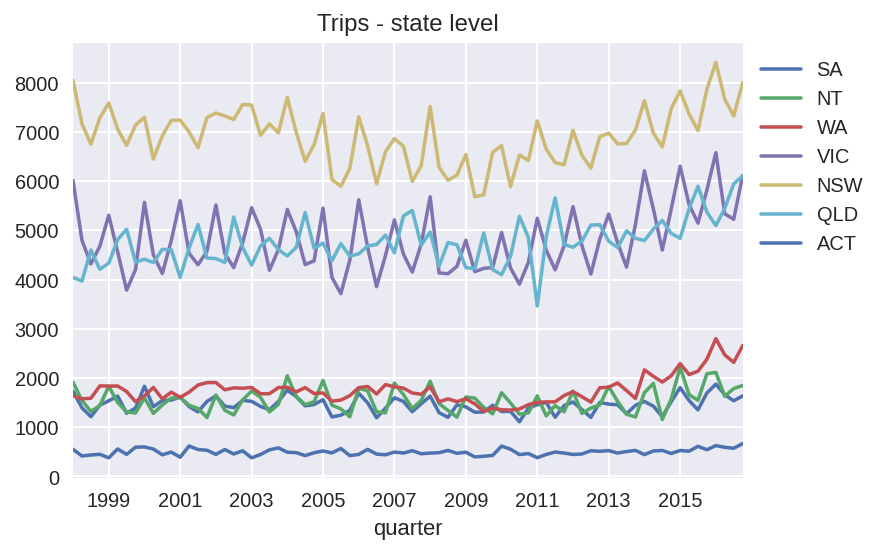

In [11]:
ax = hierarchy_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

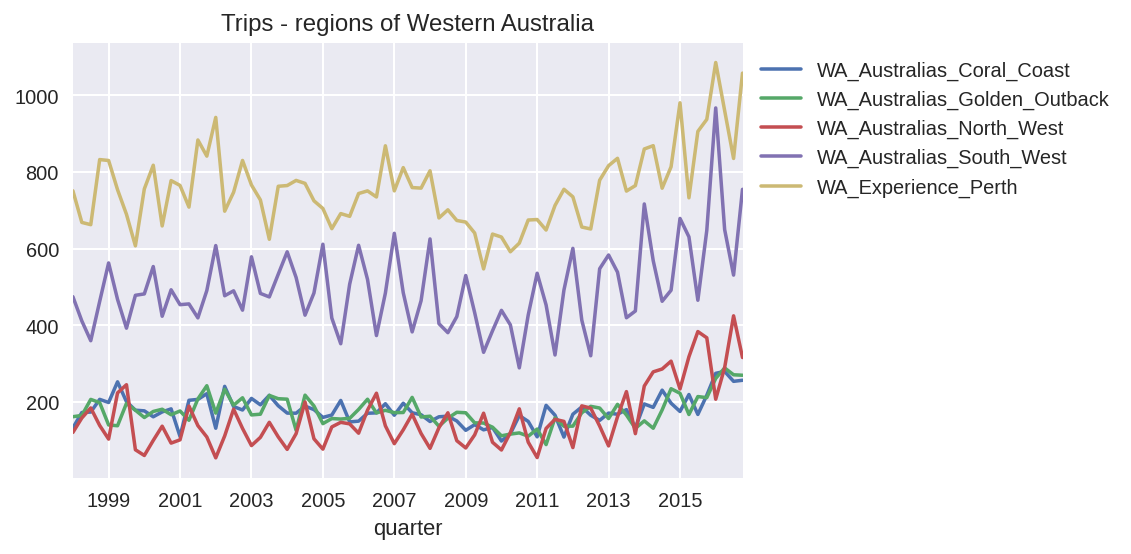

In [12]:
ax = hierarchy_df[hierarchy['WA']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));




#Orbit time series forecasting

In [13]:
from orbit.models.ets import ETSMAP
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

#  Exponential Smoothing (ETS)


In [26]:
df=hierarchy_df
df.reset_index(inplace = True)
df.head()
df.dtypes

index                           int64
quarter                datetime64[ns]
ACT_Canberra                  float64
NSW_Blue_Mountains            float64
NSW_Capital_Country           float64
                            ...      
QLD                           float64
SA                            float64
VIC                           float64
WA                            float64
total                         float64
Length: 87, dtype: object

In [27]:
test_size=20
train_df=df[:-test_size]
test_df=df[-test_size:]
train_df.head()

,index,quarter,ACT_Canberra,NSW_Blue_Mountains,NSW_Capital_Country,NSW_Central_Coast,NSW_Central_NSW,NSW_Hunter,NSW_New_England_North_West,NSW_North_Coast_NSW,NSW_Outback_NSW,NSW_Riverina,NSW_Snowy_Mountains,NSW_South_Coast,NSW_Sydney,NSW_The_Murray,NT_Alice_Springs,NT_Barkly,NT_Darwin,NT_East_Coast,NT_Hobart_and_the_South,NT_Kakadu_Arnhem,NT_Katherine_Daly,NT_Lasseter,"NT_Launceston,_Tamar_and_the_North",NT_MacDonnell,NT_North_West,NT_Tasmania,NT_Wilderness_West,QLD_Brisbane,QLD_Bundaberg,QLD_Central_Queensland,QLD_Darling_Downs,QLD_Fraser_Coast,QLD_Gold_Coast,QLD_Mackay,QLD_Northern,QLD_Outback,QLD_Sunshine_Coast,QLD_Tropical_North_Queensland,...,SA_Flinders_Ranges_and_Outback,SA_Kangaroo_Island,SA_Limestone_Coast,SA_Murraylands,SA_Riverland,SA_Yorke_Peninsula,VIC_Ballarat,VIC_Bendigo_Loddon,VIC_Central_Highlands,VIC_Central_Murray,VIC_Geelong,VIC_Gippsland,VIC_Goulburn,VIC_High_Country,VIC_Lakes,VIC_Macedon,VIC_Mallee,VIC_Melbourne,VIC_Melbourne_East,VIC_Murray_East,VIC_Peninsula,VIC_Phillip_Island,VIC_Spa_Country,VIC_Upper_Yarra,VIC_Western,VIC_Western_Grampians,VIC_Wimmera,WA_Australias_Coral_Coast,WA_Australias_Golden_Outback,WA_Australias_North_West,WA_Australias_South_West,WA_Experience_Perth,ACT,NSW,NT,QLD,SA,VIC,WA,total
0,0,1998-01-01,551.001921,195.543180,261.808142,455.166849,424.395446,674.978457,329.838506,1342.301230,96.602651,215.268912,140.989157,1257.446550,2288.955629,356.500087,20.207638,18.465206,87.607295,148.855652,380.602050,18.359518,16.771762,10.086239,247.595226,9.951165,141.241141,751.631888,63.335097,1052.194495,122.914282,191.589276,259.086028,173.961068,827.045761,128.935651,226.112807,37.196194,742.602300,220.915346,...,112.097738,34.678300,212.982623,68.004076,89.511377,160.681637,182.239342,231.685977,88.907326,196.298722,255.444832,382.608956,153.398516,320.504579,211.835892,24.790891,182.084599,1578.548409,86.852958,22.317190,694.723679,364.043288,86.196006,102.791022,739.350975,86.996591,18.804743,132.516409,161.726948,120.775450,474.858729,751.211958,551.001921,8039.794795,1914.709878,4042.779858,1732.743704,6010.424491,1641.089495,23932.544141
1,1,1998-04-01,416.025623,200.408671,238.600029,343.476758,557.011570,791.887234,328.366005,1161.108602,120.648446,336.094921,166.586342,795.074559,1814.459479,312.291189,56.356223,7.510969,116.864811,106.221127,226.909579,52.845863,40.806116,34.845044,172.854001,4.707126,144.696445,534.181412,42.607076,950.414816,110.058311,288.445257,439.035287,129.738887,680.774502,131.950023,159.481069,107.999764,609.883333,253.097616,...,122.200254,9.057817,154.772875,36.783256,98.747855,104.324252,136.663870,221.580799,105.157731,198.161741,190.532461,267.978316,177.725751,355.467743,245.945174,54.571687,186.326419,1506.071351,58.932986,30.996086,246.630629,166.243645,74.356890,74.855136,359.626051,84.939977,52.482311,172.615379,164.973780,158.404387,411.622281,668.710707,416.025623,7166.013805,1541.405790,3967.069713,1394.638319,4795.246755,1576.326534,20856.726540
2,2,1998-07-01,436.029011,253.359689,184.423751,303.670875,555.527970,566.040599,324.859168,839.368066,110.073779,228.065371,372.815339,643.280546,1989.731939,376.718698,110.918441,43.565625,179.903793,40.462620,176.902440,49.458990,81.973366,42.975636,90.604553,19.641008,75.054449,391.507192,18.851214,1002.765191,129.551542,288.227317,417.396506,182.498711,839.015762,154.908638,228.857258,234.743482,615.306331,423.506735,...,103.429609,10.464381,97.735163,43.497197,64.026915,68.996468,117.642761,128.054955,98.756975,112.972132,217.110171,257.236810,157.503674,356.656700,197.998048,21.606748,187.347077,1522.214955,66.816989,30.265351,183.430857,83.032823,60.778546,59.465405,342.321758,79.974884,35.657551,173.904335,206.879934,184.619035,360.039657,662.850731,436.029011,6747.935790,1321.819326,4598.548477,1213.330723,4316.845170,1588.293692,20222.802189
3,3,1998-10-01,449.798445,245.573846,229.088938,331.817060,590.158435,591.568947,279.796195,1183.859971,185.470023,201.123526,126.429852,829.914258

In [28]:
hierarchy_df.shape

(76, 87)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.


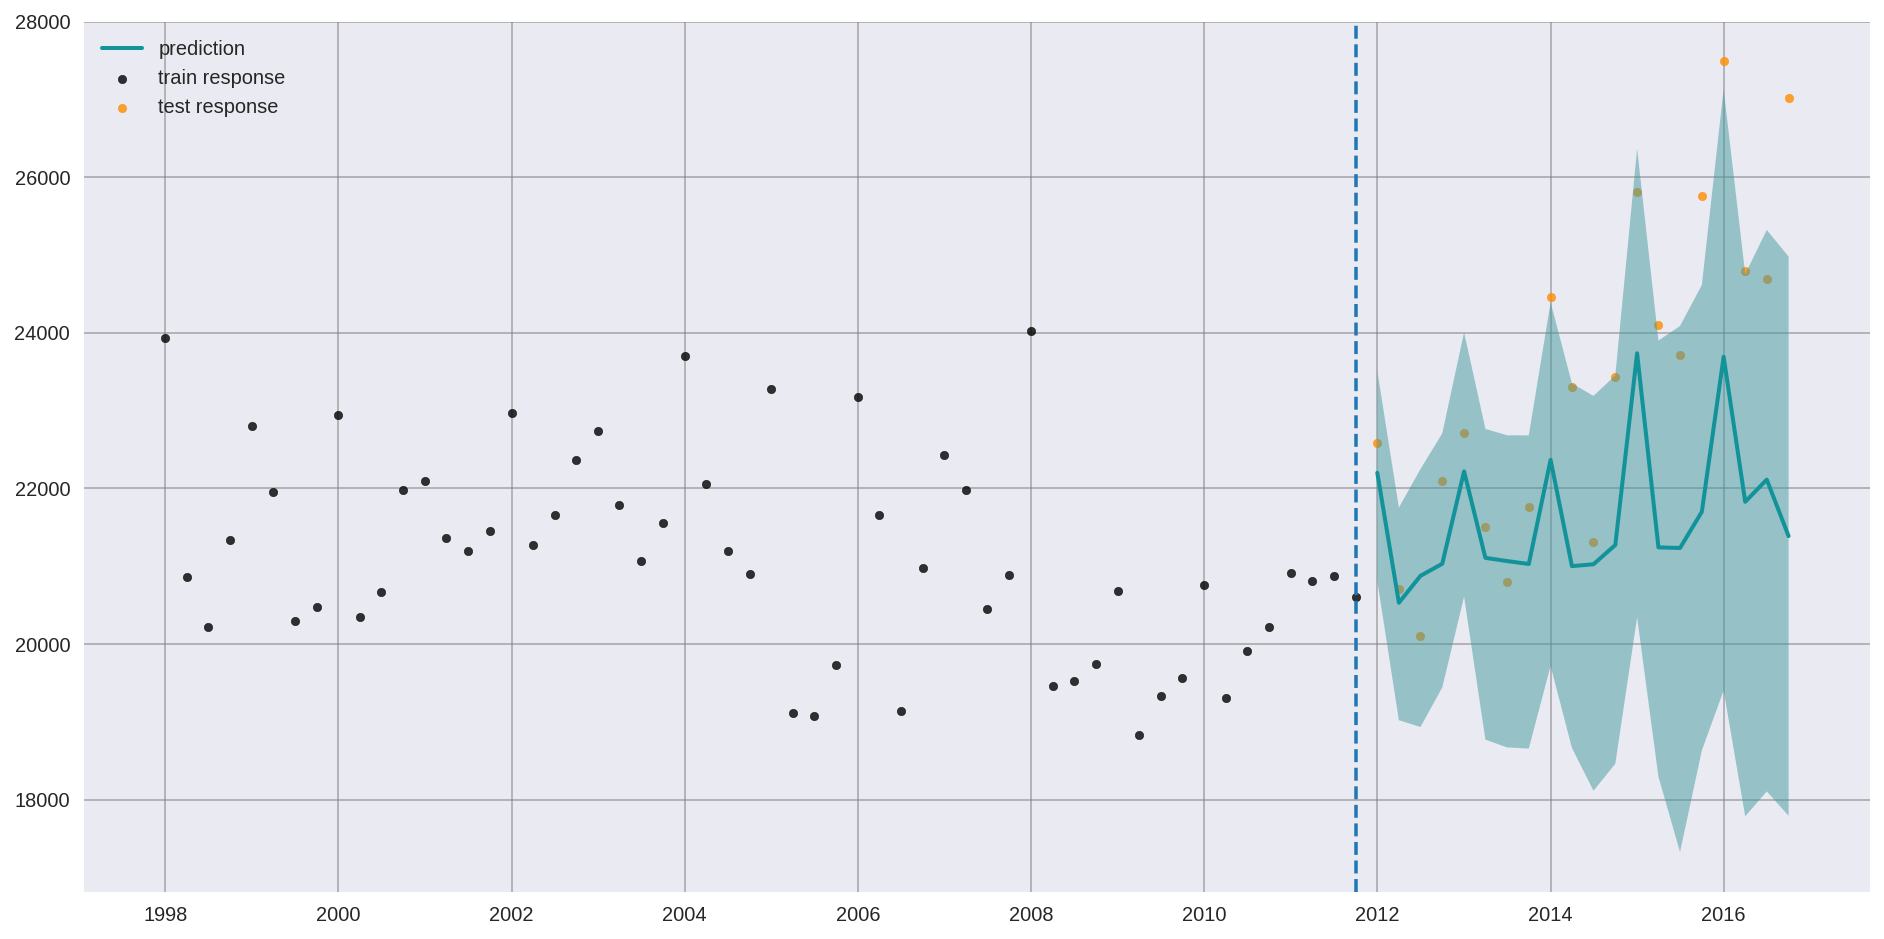

<AxesSubplot:>

In [29]:
dlt = DLTFull(
    response_col='total', date_col='quarter',
    regressor_col=['SA', 'SA_Adelaide_Hills'],
    seasonality=4,
)
dlt.fit(df=train_df)

# outcomes data frame
predicted_df = dlt.predict(df=test_df)

plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)

In [43]:
from sklearn.metrics import mean_squared_error

from statsmodels.tools.eval_measures import rmse

arr=np.array(df.total)
arr1=np.array(predicted_df.prediction)

print('RMSE',rmse(arr[-test_size:],arr1))

RMSE 23477.147805845296


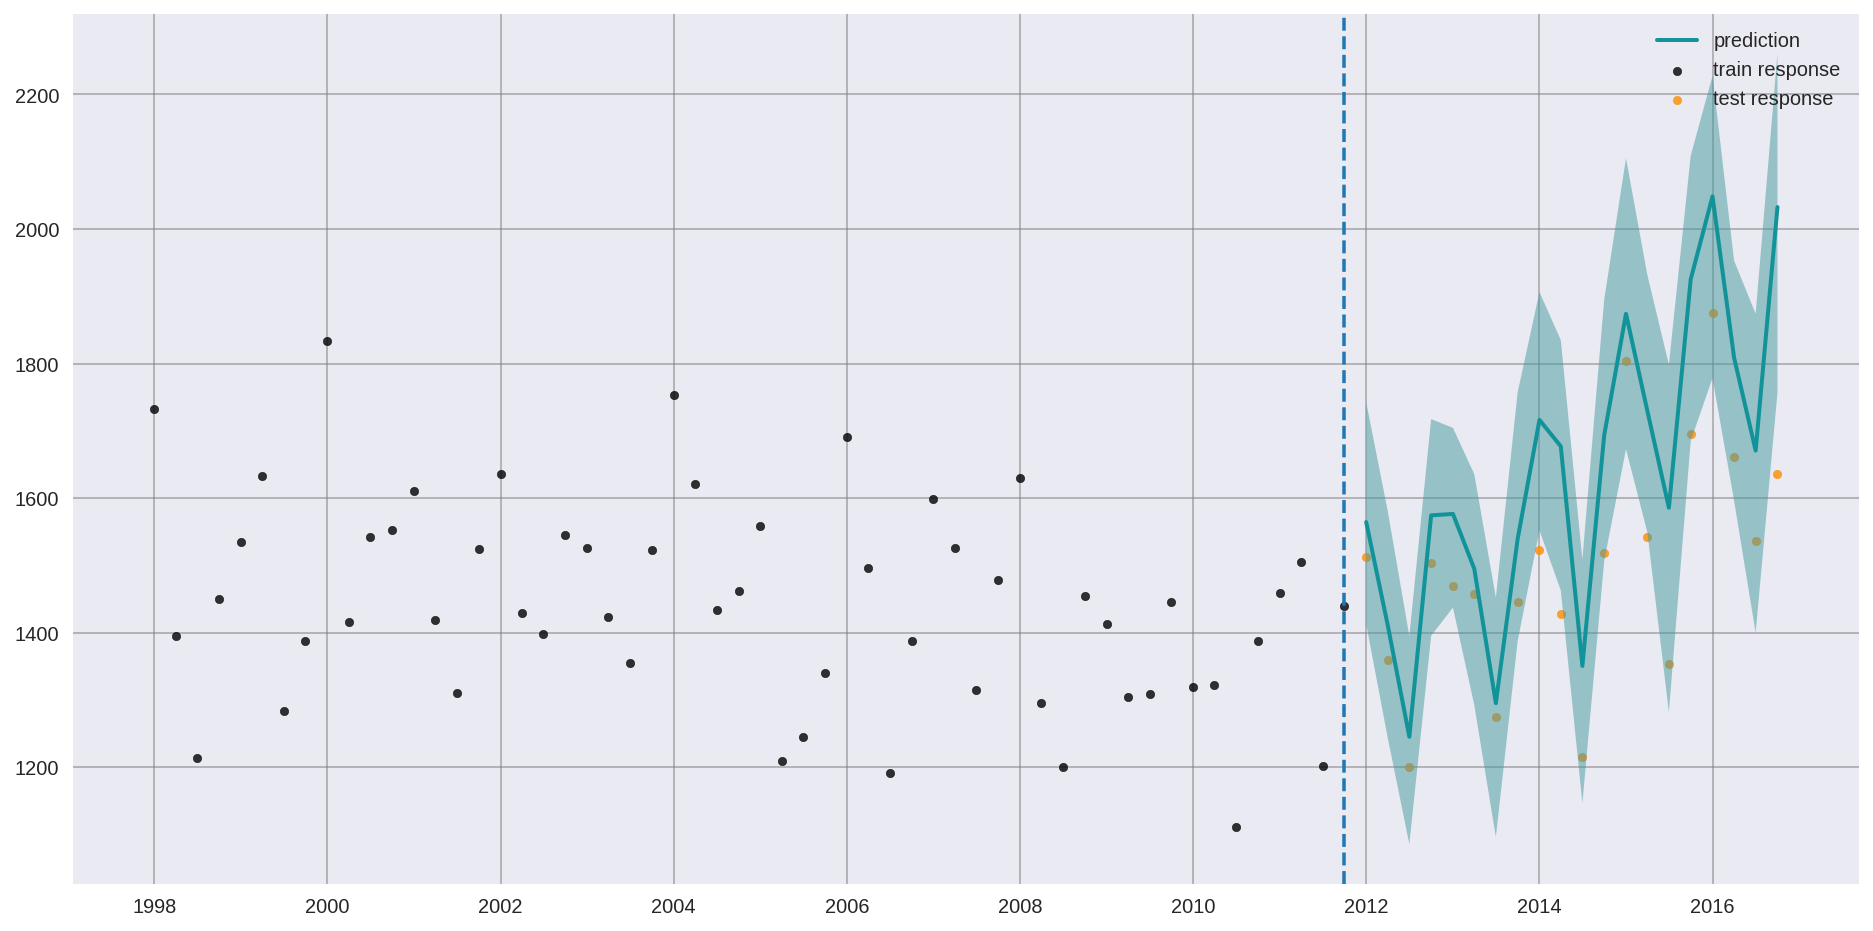

RMSE 166.9797055066929


In [41]:
dlt = DLTFull(
    response_col='SA', date_col='quarter',
    regressor_col=['total', 'SA_Adelaide_Hills'],
    seasonality=4,
)
dlt.fit(df=train_df)

# outcomes data frame
predicted_df = dlt.predict(df=test_df)

plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)
from statsmodels.tools.eval_measures import rmse

arr=np.array(df.SA)
arr1=np.array(predicted_df.prediction)

print('RMSE',rmse(arr[-test_size:],arr1))

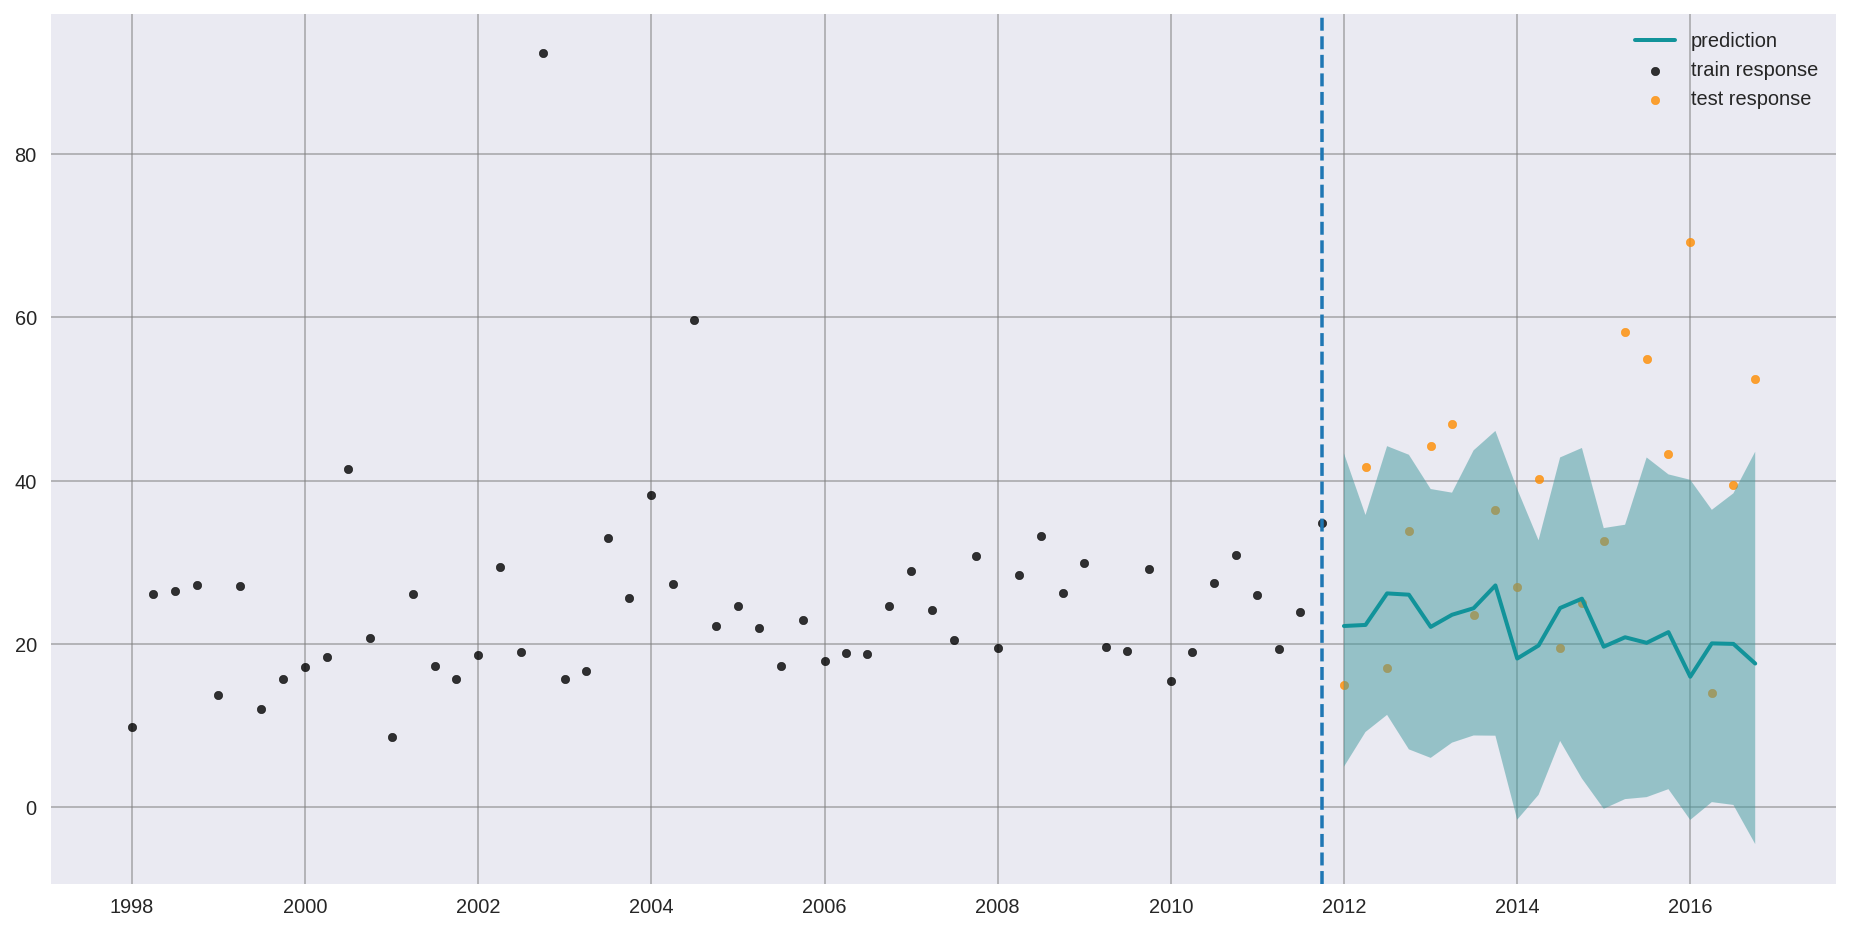

RMSE 22.29275996773605


In [42]:
dlt = DLTFull(
    response_col='SA_Adelaide_Hills', date_col='quarter',
    regressor_col=['total', 'SA'],
    seasonality=4,
)
dlt.fit(df=train_df)

# outcomes data frame
predicted_df = dlt.predict(df=test_df)

plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)
from statsmodels.tools.eval_measures import rmse

arr=np.array(df.SA_Adelaide_Hills)
arr1=np.array(predicted_df.prediction)

print('RMSE',rmse(arr[-test_size:],arr1))